In [1]:
import json
from netCDF4 import Dataset
import numpy as np
import matplotlib.pyplot as plt
import scipy 

In [2]:
ncin = Dataset( "tcvx23.nc")

Text(0, 0.5, '$B_\\varphi$ [T]')

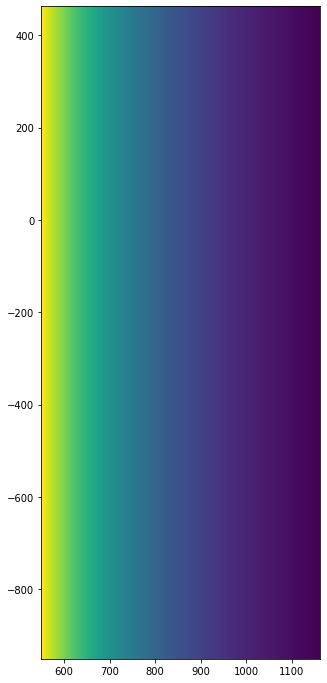

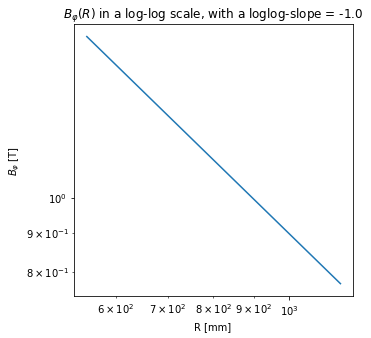

In [3]:
x=ncin['x'][:]
y=ncin['y'][:]
z=ncin['z'][:]
BR=ncin['BR'][:]
BZ=ncin['BZ'][:] # toroidal
BP=ncin['BP'][:]
Pot=ncin['potential'][0,:,:,:] # t,z,y,x  and only 1 time
np.shape(np.array(x))

# R, Z , phi

# (R,Z,phi) => interpolate BR,BZ,BP & potential_E 
# BR 


plt.figure(figsize=(5,12))
plt.pcolormesh(x,y,BP[0,:,:]) # units are mm for R and Z

plt.figure(figsize=(5,5))
plt.loglog(x,BP[0,470,:]*x)
fit=np.polyfit(np.log(x),np.log(BP[0,470,:]*x),1) # so.. BP * x er vores B_varphi data
plt.xlim=(np.log(x)[0]*0.9,np.log(x)[-1]*1.1)
plt.title(r"$B_\varphi(R)$ in a log-log scale, with a"+f" loglog-slope = {fit[0]:.1f}")
plt.xlabel("R [mm] ")
plt.ylabel(r"$B_\varphi$ [T]")
# plt.savefig("B_loglog_contravar.pdf",bbox_inches="tight")

In [4]:
y[470]
z[200]

3.2806737

In [5]:
ncin.variables.keys()

dict_keys(['z', 'y', 'x', 'BR', 'BZ', 'BP', 'Psip', 'vol3d', 'xc', 'yc', 'zc', 'zf', 'yf', 'xf', 'xfc', 'yfc', 'zfc', 'time', 'timef', 'electrons', 'electronsFF', 'ions', 'ionsFF', 'Ue', 'UeFF', 'Ui', 'UiFF', 'potential', 'potentialFF', 'aparallel', 'aparallelFF'])

In [140]:
np.argmin(np.abs(z-np.pi/2))
z[95]

1.5626152

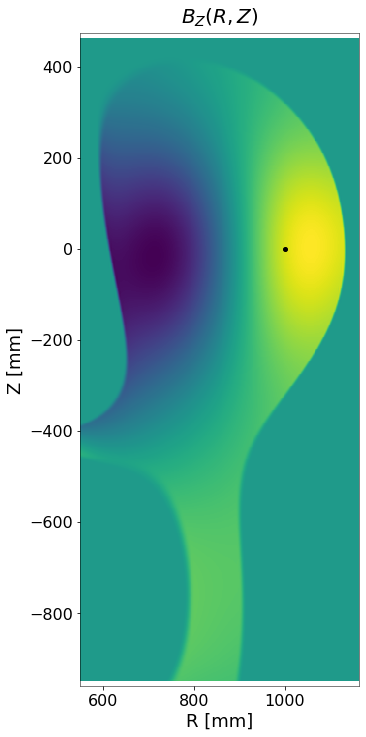

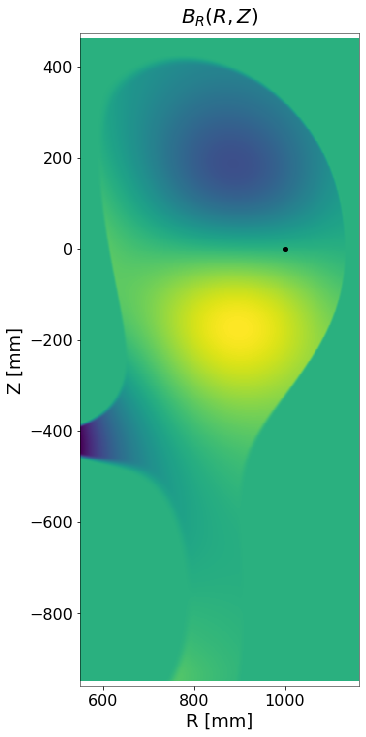

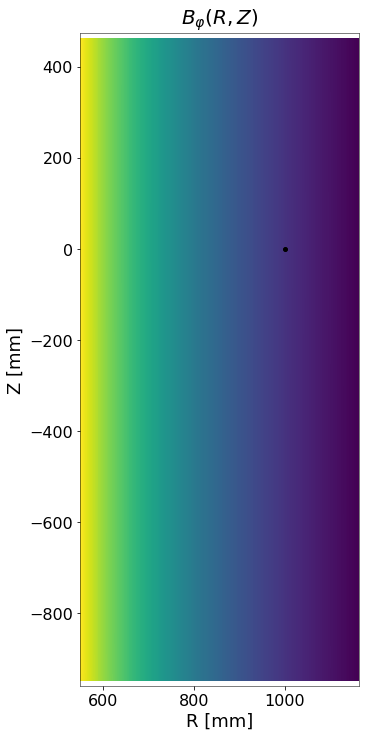

In [147]:
idx=95
plt.figure(figsize=(5,12))
plt.axis("equal")
plt.pcolormesh(x,y,BZ[idx,:,:]) # units are mm for R and Z
plt.plot(1000,0,'o',markersize=4,color="black")
plt.title(r"$B_Z(R,Z)$")
plt.xlabel("R [mm]")
plt.ylabel("Z [mm]")
# plt.savefig("BZ.pdf",bbox_inches="tight")

plt.figure(figsize=(5,12))
plt.axis("equal")
plt.pcolormesh(x,y,BR[idx,:,:]) # units are mm for R and Z
plt.plot(1000,0,'o',markersize=4,color="black")
plt.title(r"$B_R(R,Z)$")
plt.xlabel("R [mm]")
plt.ylabel("Z [mm]")
# plt.savefig("BR.pdf",bbox_inches="tight")

plt.figure(figsize=(5,12))
plt.axis("equal")
plt.pcolormesh(x,y,(BP*x)[idx,:,:]) # units are mm for R and Z
plt.plot(1000,0,'o',markersize=4,color="black")
plt.title(r"$B_\varphi(R,Z)$")
plt.xlabel("R [mm]")
plt.ylabel("Z [mm]")
# plt.savefig("Bvarphi.pdf",bbox_inches="tight")

In [7]:
ncin.variables["z"]
z[1] # 0,6.29
z[2]-z[1] # stepsize 0.016
(z[-1]-z[0])-2*np.pi # so 2pi all the way around. nice.
# np.pi*2

1.7484556025237907e-07

In [8]:
print( "FILE CONTENTS")
for v in ncin.variables:
    if v == "time" or v == "timef": 
        print(f"{v} {ncin.variables[v].shape}")
    else : 
        print( f"{v} {ncin.variables[v].shape}",
            f"\t{ ncin.variables[v].long_name}")
ncin.close()

FILE CONTENTS
z (385,) 	z-coordinate in Computational coordinate system
y (696,) 	y-coordinate in Computational coordinate system
x (288,) 	x-coordinate in Computational coordinate system
BR (385, 696, 288) 	R-component of magnetic field in cylindrical coordinates
BZ (385, 696, 288) 	Z-component of magnetic field in cylindrical coordinates
BP (385, 696, 288) 	Contravariant P-component of magnetic field in cylindrical coordinates
Psip (385, 696, 288) 	Flux-function psi
vol3d (385, 696, 288) 	Volume form in 3d
xc (385, 696, 288) 	x-coordinate in Cartesian coordinate system
yc (385, 696, 288) 	y-coordinate in Cartesian coordinate system
zc (385, 696, 288) 	z-coordinate in Cartesian coordinate system
zf (64,) 	zf-coordinate in Computational coordinate system
yf (696,) 	yf-coordinate in Computational coordinate system
xf (288,) 	xf-coordinate in Computational coordinate system
xfc (64, 696, 288) 	xf-coordinate in Cartesian coordinate system
yfc (64, 696, 288) 	yf-coordinate in Cartesian coo

In [9]:
print((np.min(BR),np.max(BR))) # BR
print((np.min(BZ),np.max(BZ))) # BZ
print((np.min(BP*x),np.max(BP*x))) # B varphi

print((np.min(x),np.max(x))) # R
print((np.min(y),np.max(y))) # Z 
print((np.min(z),np.max(z))) # varphi


(-0.20897119, 0.11960504)
(-0.205056, 0.17448835)
(0.7708716, 1.6265552)
(551.35767, 1162.0569)
(-949.49207, 461.73175)
(0.008181231, 6.2913666)


Now that data is investigated - let us simulate

In [65]:
from IPT import Particle, ParticleSystem, RK4, f
plt.rcParams.update({
             'axes.labelsize': 18,
             'axes.titlesize': 20,
             'xtick.labelsize': 16,
             'ytick.labelsize': 16,
             'axes.linewidth': 0.5,
             'legend.fontsize': 16,
             'legend.title_fontsize': 18,
             'axes.titlepad': 10
                            })
# setting constants 
mp=1.672621e-27 # mass proton, [mp]=kg
mn=1.674927e-27 # mass neutron, [mn]=kg
me=9.109382e-31 # mass electron, [me]=kg
m_amu=1.660539e-27 # Dalton, [m_amu]=kg
qe=1.602176e-19 # elementary charge, [qe]=C
kB=1.380e-23
###
T_eV=1e1 #[T_eV]=eV, char temp in outer edge ~10eV # make this into a distribution later
T_K=(kB/qe)**-1*T_eV # J/K*(J/eV)**-1= eV/K so invert => 1e4 K/eV
Z_W=184
ms=Z_W*mp


def omega_cs(qs,B,ms):
    # q charge in integer (integers elementary charge)
    # B in tesla
    # ms in kg
    q=qs*qe
    return abs(q)*B/ms

def tau_cs(qs,B,ms):
    return (omega_cs(qs,B,ms)/(2*np.pi))**-1

def vth(T_eV,ms):
    # T in eV -> T in J
    return (3/2*2*(T_eV*qe)/ms)**0.5


print(f"Temperature is T={T_eV:.2f} eV = {T_K:.2e} K")

print(f"speed is {vth(T_eV,ms):.2e} m/s")

print(f"cyclotron period {tau_cs(1,1,ms):.2e} s")

Temperature is T=10.00 eV = 1.16e+05 K
speed is 3.95e+03 m/s
cyclotron period 1.21e-05 s


In [77]:
#choosing dt
import ase.data

atomic_masses = { k: ase.data.atomic_masses[v] 
                 for k,v in ase.data.atomic_numbers.items() }
ms=atomic_masses['W']*m_amu
qs=1
# lets take the dt for ~2 T, a quite high field, and then divide that circ motion into 100
N_dt=100
dt=tau_cs(qs,2,ms)/N_dt
dt

5.985890144189745e-08

In [12]:
np.dot(np.array([1,2,3]).reshape(1,3),np.array([1,2,3]).reshape(1,3).T)

array([[14]])

In [63]:
Feltor_data=(x,y,z,BR,BZ,BP*x) # format needed in f

p1=Particle('W',position=[1,0,0],velocity=[1e3,0.1,0])
sys1=ParticleSystem([p1])
model=f(B_choice=3,B_R0=1,FELTOR_data=Feltor_data)
dyn=RK4(sys1,model=model,timestep=dt)

model.r_cyl(np.array([1,0,0]))

model.B_interpolate_cyl(model.r_cyl(np.array([1,0,0])).reshape(1,3))

/Users/larsthorsorensen/Desktop/DTU/10. Semester/Tungsten_transport_Tokamak/code/Data/IPT_3.py:330: RuntimeWarning: divide by zero encountered in long_scalars
  pre_angle=np.arctan(x/y)


array([0.00193075, 0.15077294, 0.89652763])

In [14]:
model.r_cyl(p1.get_position())

/Users/larsthorsorensen/Desktop/DTU/10. Semester/Tungsten_transport_Tokamak/code/Data/IPT_3.py:330: RuntimeWarning: divide by zero encountered in double_scalars
  pre_angle=np.arctan(x/y)


array([1000.        ,    0.        ,    1.57079633])

In [15]:
N_loop=100 # how many loops
N_i=1 # number of calc in each loop
N_tot=N_loop*N_i # total calculations inside loop

#### run simulation

## initialize 
r_ex1=[]
v_ex1=[]
RZvarphi_ex1=[]
# init pos & vel 

r_ex1.append(sys1.get_positions().reshape(3,))
v_ex1.append(sys1.get_velocities().reshape(3,))
# r,v wil be (N_tot+1 , 3)  dimensional
RZvarphi_ex1.append(model.r_cyl(p1.get_position()))

dyn.run(1)
for i in range(N_loop):
    dyn.run(N_i)
    r_ex1.append(sys1.get_positions().reshape(3,)) # reshape from (1,3) -> (3,)
    v_ex1.append(sys1.get_positions().reshape(3,))
    RZvarphi_ex1.append(model.r_cyl(p1.get_position()))

r_ex1=np.array(r_ex1)
v_ex1=np.array(v_ex1)
RZvarphi_ex1=np.array(RZvarphi_ex1)


In [16]:
Bsize=((BP[0,:,:]*x)**2+BR**2+BZ**2)**0.5

In [17]:
# char r_L
np.linalg.norm(model.B_interpolate(model.r_cyl(np.array([0.85,0,0])).reshape(1,3)))

1e3/omega_cs(1,1.0575,ms) # so 1.8 mm
# RZvarphi_ex1[:,1]

0.0018017664401945269

In [18]:
if (1>0) and (-1<0):
    print("yes")

yes


In [19]:
x_lims=[np.min(RZvarphi_ex1[:,0]),np.max(RZvarphi_ex1[:,0])]
y_lims=[np.min(RZvarphi_ex1[:,1]),np.max(RZvarphi_ex1[:,1])]

In [97]:
Feltor_data=(x,y,z,BR,BZ,BP*x) # format needed in f

p1=Particle('W',position=[1,0.001,0],velocity=[0,0,1e3])
sys1=ParticleSystem([p1])
model=f(B_choice=3,B_R0=1,FELTOR_data=Feltor_data)
dyn=RK4(sys1,model=model,timestep=dt)

model.r_cyl(np.array([1,0.001,0]))

# model.B_interpolate(model.r_cyl(np.array([1,0,0])).reshape(1,3))

array([1000.0005    ,    0.        ,    1.56979633])

In [98]:
N_loop=100 # how many loops
N_i=1 # number of calc in each loop
N_tot=N_loop*N_i # total calculations inside loop

#### run simulation

## initialize 
r_ex1=[]
v_ex1=[]
RZvarphi_ex1=[]
B_field_cyl=[]
B_field_cart=[]
# init pos & vel 

r_ex1.append(sys1.get_positions().reshape(3,))
v_ex1.append(sys1.get_velocities().reshape(3,))
# r,v wil be (N_tot+1 , 3)  dimensional
RZvarphi_ex1.append(model.r_cyl(p1.get_position()))

dyn.run(1)
for i in range(N_loop):
    dyn.run(N_i)
    r_ex1.append(sys1.get_positions().reshape(3,)) # reshape from (1,3) -> (3,)
    v_ex1.append(sys1.get_positions().reshape(3,))
    RZvarphi_ex1.append(model.r_cyl(p1.get_position()))
    B_field_cyl.append(model.B_interpolate_cyl(model.r_cyl(p1.get_position()).reshape(1,3)))
    B_field_cart.append(model.B_interpolate(model.r_cyl(p1.get_position()).reshape(1,3)))

r_ex1=np.array(r_ex1)
v_ex1=np.array(v_ex1)
RZvarphi_ex1=np.array(RZvarphi_ex1)
B_field_cyl=np.array(B_field_cyl)
B_field_cart=np.array(B_field_cart)


In [124]:
B_field_cart[0,:]

array([ 0.00271717, -0.89654896,  0.15075715])

In [125]:
B_field_cyl[0,:]

array([0.00182063, 0.15075715, 0.89655122])

In [120]:
R_t,Z_t,varphi_t=RZvarphi_ex1[0,:].reshape(-1)
varphi_t
(np.sin(varphi_t)) # x
(np.cos(varphi_t)) # y

varphi_t=np.pi/2
np.array([np.cos(varphi_t),-np.sin(varphi_t),0])

array([ 6.123234e-17, -1.000000e+00,  0.000000e+00])

In [74]:
RZvarphi_ex1[0,0],RZvarphi_ex1[0,1]

(1000.000499999875, 0.0)

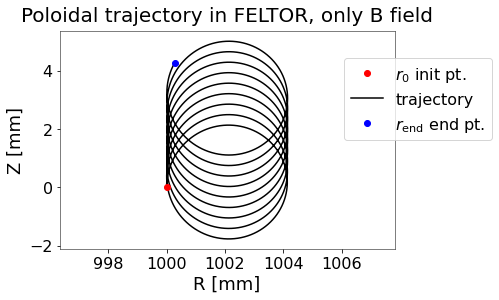

In [80]:

plt.figure()
plt.plot(RZvarphi_ex1[0,0],RZvarphi_ex1[0,1],'o',zorder=2,markersize=6,color="red",label=r"$r_0$ init pt.")
plt.plot(RZvarphi_ex1[:,0],RZvarphi_ex1[:,1],'-',zorder=1,color="black",label="trajectory")
plt.plot(RZvarphi_ex1[-1,0],RZvarphi_ex1[-1,1],'o',zorder=2,markersize=6,color="blue",label=r"$r_\mathrm{end}$ end pt.")
plt.xlabel("R [mm]")
plt.ylabel("Z [mm]")
plt.axis("equal")
# plt.ylim=(-2,2)
# plt.xlim=(997,1003)
# ax=plt.gca()
# ax.set_aspect('equal',adjustable="box")
# plt.pcolormesh(x,y,Bsize[0,:,:]) # ... only 
# plt.xlim([600,800])
plt.xlim=(x_lims[0],x_lims[1])
plt.ylim=(y_lims[0],y_lims[1])
plt.title("Poloidal trajectory in FELTOR, only B field")
plt.legend(loc=[0.85,0.5])
# plt.savefig("FELTOR_traj.pdf",bbox_inches="tight")

In [81]:
dyn.timestep
B_field[0,:]

array([ 0.00271717, -0.89654896,  0.15075715])

In [69]:
Bchar=np.linalg.norm(B_field,axis=1)[0]
1e3/omega_cs(Bchar,1,ms)

0.00212032658684313

In [22]:
np.linalg.norm(B_field,axis=1)

array([0.90913978, 0.9091367 , 0.90913237, 0.90912681, 0.90912   ,
       0.90911197, 0.90910271, 0.90909224, 0.90908055, 0.90906766,
       0.90905359, 0.90903834, 0.9090219 , 0.90900426, 0.90898549,
       0.90896559, 0.90894459, 0.9089225 , 0.90889934, 0.90887508,
       0.90884978, 0.90882346, 0.90879614, 0.90876785, 0.90873862,
       0.90870846, 0.9086774 , 0.90864546, 0.90861267, 0.90857907,
       0.90854466, 0.90850949, 0.90847358, 0.90843695, 0.90839965,
       0.9083617 , 0.90832312, 0.90828396, 0.90824425, 0.908204  ,
       0.90816327, 0.90812208, 0.90808046, 0.90803845, 0.90799608,
       0.90795339, 0.90791041, 0.90786718, 0.90782373, 0.90778009,
       0.90773631, 0.90769241, 0.90764844, 0.90760442, 0.9075604 ,
       0.9075164 , 0.90747247, 0.90742864, 0.90738495, 0.90734143,
       0.90729809, 0.90725492, 0.90721202, 0.90716943, 0.90712719,
       0.90708533, 0.90704388, 0.90700288, 0.90696235, 0.90692234,
       0.90688288, 0.90684399, 0.90680571, 0.90676806, 0.90673

In [23]:
# np.linalg.norm(np.array([-0.00560959,  0.29683521,  0.1484176 ]))

In [24]:
print(model.B_interpolate(model.r_cyl(np.array([1,0.001,0])).reshape(1,3)))
print(model.B_interpolate_cyl(model.r_cyl(np.array([1,0.001,0])).reshape(1,3)))

# seems to be different
print(np.linalg.norm(model.B_interpolate(model.r_cyl(np.array([1,0.001,0])).reshape(1,3))))
print(np.linalg.norm(model.B_interpolate_cyl(model.r_cyl(np.array([1,0.001,0])).reshape(1,3))))

[ 0.00282459 -0.89655184  0.15075259]
[0.00192803 0.15075259 0.89655422]
0.9091421923626477
0.9091421923626478


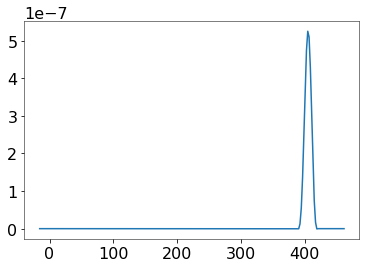

In [107]:
# plt.pcolormesh(x,y,BZ[0,:,:]) # ... only 
plt.plot(y[460:],BZ[0,460:,0])


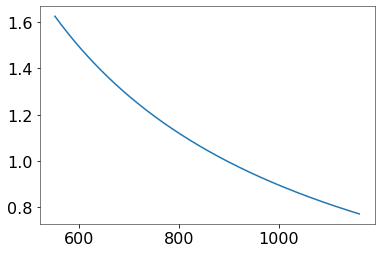

In [78]:
plt.plot(x,BP[0,0,:]*x)

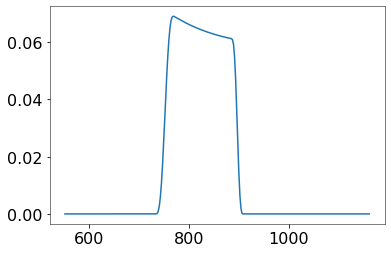

In [79]:
plt.plot(x,BZ[0,0,:])

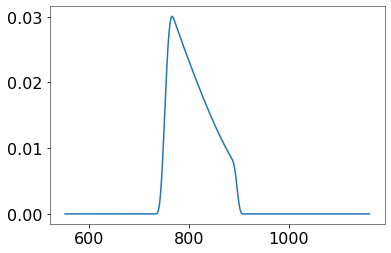

In [80]:
plt.plot(x,BR[0,0,:])

In [16]:
# 1,0,0 interpoleres som 

In [17]:
np.dot(model.e_R(np.array([1,1,1])),np.array([1,1,1]))

1.414213562373095

In [20]:
from scipy.interpolate import RegularGridInterpolator

In [21]:
Feltor_data=(x,y,z,BR,BZ,BP*x) # format needed in f

p1=Particle('W',position=[1,0,0],velocity=[1e3,0.1,0])
sys1=ParticleSystem([p1])
model=f(B_choice=3,B_R0=1,FELTOR_data=Feltor_data)
dyn=RK4(sys1,model=model,timestep=dt)

print(model.r_cyl(np.array([1,0,0])))

model.B_interpolate(model.r_cyl(np.array([1,0,0])).reshape(1,3))

[1000.            0.            1.57079633]


/Users/larsthorsorensen/Desktop/DTU/10. Semester/Tungsten_transport_Tokamak/code/Data/IPT_3.py:307: RuntimeWarning: divide by zero encountered in long_scalars
  pre_angle=np.arctan(x/y)


ValueError: shapes (1,) and (3,1) not aligned: 1 (dim 0) != 3 (dim 0)

In [28]:
# x,y,z = R,Z,varphi
# BR, BZ, BP*x
# np.shape(np.array(BR))
# np.shape(x)
# int_BR=RegularGridInterpolator((np.array(x),np.array(y),np.array(z)),np.array(BR))
# BR is in z y x format
int_BR=RegularGridInterpolator((z,y,x),BR)
int_BZ=RegularGridInterpolator((z,y,x),BZ)
int_Bvarphi=RegularGridInterpolator((z,y,x),BP*x)
# r_cyl_test = z_test, y_test, x_test = varphi, Z, R
test_pt=np.array([[np.pi/2,0,1000]])

print(np.shape(np.array([int_BR(test_pt),int_BZ(test_pt),int_Bvarphi(test_pt)])))
np.array([int_BR(test_pt),int_BZ(test_pt),int_Bvarphi(test_pt)])

int_BZ(test_pt)[0]


(3, 1)


0.15077294323069307

In [29]:
np.dot(np.array([1,2,3]),np.array([1,0,0]))

1